# Лабораторная работа 1

### Генерация нелинейных регрессий

Сгенерируем три случайные регрессии с помощью make_regression из sklearn и применим к ним нелинейные преобразования. Выставим регрессиям разные параметры.


*   Первой регресии поставим наименьшее значение шума и сделаем её самой обусловленной.
*   Второй регресии поставим самое высокое значения шума и среднюю обусловленность.
*   Третюю модель сделаем плохо обусловленной и средней по шуму.



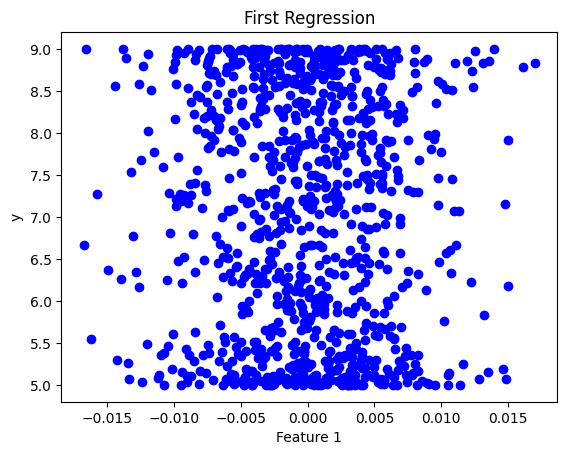

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression

seed = 42
n_samples = 1000
n_features = 100
n_output = 1

X1, y1 = make_regression(
    n_samples=n_samples,
    n_features=n_features,
    n_targets=n_output,
    noise=5,
    effective_rank=2,
    random_state=seed
)

y1 = 2 * np.sin(1.2 * y1) + 7

plt.scatter(X1[:, 0], y1, color='blue')
plt.title('First Regression')
plt.xlabel('Feature 1')
plt.ylabel('y')
plt.show()

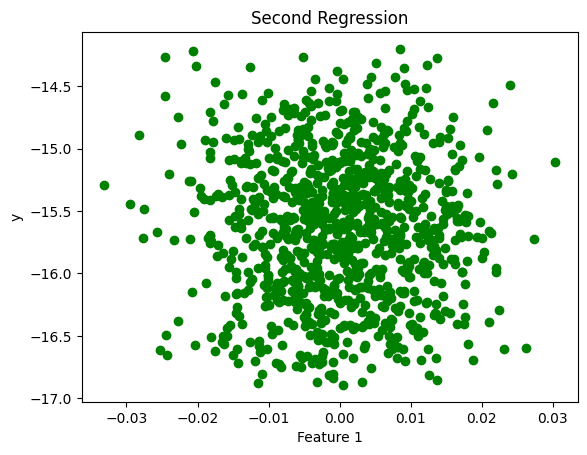

In [ ]:
X2, y2 = make_regression(
    n_samples=n_samples,
    n_features=n_features,
    n_targets=n_output,
    noise=30,
    effective_rank=7,
    random_state=seed
)

y2 = 0.3 * np.sqrt(np.abs(y2) + 0.1) - 17

plt.scatter(X2[:, 0], y2, color='green')
plt.title('Second Regression')
plt.xlabel('Feature 1')
plt.ylabel('y')
plt.show()

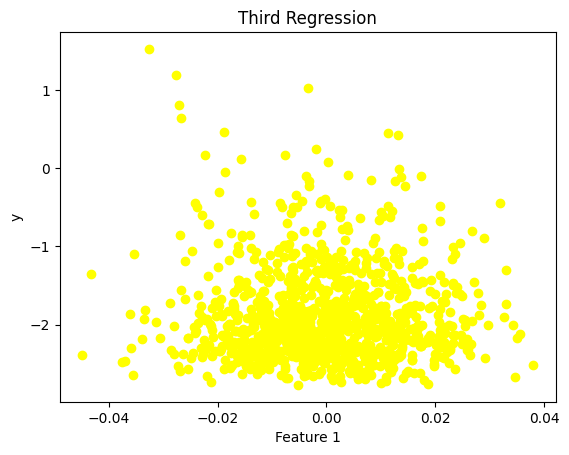

In [ ]:
X3, y3 = make_regression(
    n_samples=n_samples,
    n_features=n_features,
    n_targets=n_output,
    noise=10,
    effective_rank=15,
    random_state=seed
)

y3 = np.exp(0.05 * y3) - 3

plt.scatter(X3[:, 0], y3, color='yellow')
plt.title('Third Regression')
plt.xlabel('Feature 1')
plt.ylabel('y')
plt.show()

### Реализуем модель

In [ ]:
import torch
import torch.nn as nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        m.bias.data.fill_(0.01)

class RegressionModel(nn.Module):
    def __init__(
            self,
            input_size=n_features,
            hidden_size=300,
            output_size=n_output,
            use_batch_norm=False,
            use_dropout=False,
            dropout_rate=0.5
    ):
        super(RegressionModel, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size) if use_batch_norm else None
        self.dropout1 = nn.Dropout(dropout_rate) if use_dropout else None
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size) if use_batch_norm else None
        self.dropout2 = nn.Dropout(dropout_rate) if use_dropout else None
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.apply(init_weights)

    def forward(self, x):
        x = self.fc1(x)
        if self.bn1:
            x = self.bn1(x)
        x = self.relu(x)
        if self.dropout1:
            x = self.dropout1(x)
        x = self.fc2(x)
        if self.bn2:
            x = self.bn2(x)
        x = self.relu(x)
        if self.dropout2:
            x = self.dropout2(x)
        x = self.fc3(x)
        return x

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch import optim


device = 'cuda' if torch.cuda.is_available() else 'cpu'

n_hidden = 300
epochs = 20
criterion = nn.MSELoss()

def train(X_train, y_train, model, batch_size):
    X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
    y_train = torch.tensor(y_train, dtype=torch.float32, device=device)

    data_train = list(zip(X_train, y_train))
    train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)

    optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-5)

    model.train()

    total_loss = []

    for _ in tqdm(range(epochs)):
        loss_over_epoch = []

        for batch in train_loader:
            data, labels = batch
            data = data.to(device)
            labels = labels.to(device)
            labels = labels.unsqueeze(1)

            optimizer.zero_grad()

            pred = model(data)
            loss = criterion(pred, labels)
            loss.backward()
            loss_over_epoch.append(loss.detach().cpu())

            optimizer.step()

        total_loss.append(np.mean(loss_over_epoch))

    return total_loss


def test(X_test, y_test, model, batch_size):
    X_test = torch.tensor(X_test, dtype=torch.float32, device=device)
    y_test = torch.tensor(y_test, dtype=torch.float32, device=device)

    data_test = list(zip(X_test, y_test))

    test_loader = DataLoader(data_test, batch_size=batch_size, shuffle=False)

    model.eval()
    errors = []

    with torch.no_grad():
        for batch in test_loader:
            data, labels = batch
            data = data.to(device)
            labels = labels.to(device)
            labels = labels.unsqueeze(1)

            pred = model(data)
            error = criterion(pred, labels)
            errors.append(error.detach().cpu())

    return np.mean(errors)

def run(X, y, model, batch_size):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=seed)
    train_total_loss = train(X_train, y_train, model, batch_size)
    test_error = test(X_test, y_test, model, batch_size)
    return train_total_loss, test_error

### Часть 1. Тестирование модели с разными размерами батча

In [ ]:
batch_sizes = [16, 32, 256]
def test_batch_norm(X, y, title):
    for batch_size in batch_sizes:
        train_total_loss, test_error = run(X, y, RegressionModel(use_batch_norm=True), batch_size)
        print(f'Test error for batch size={batch_size}: {test_error}')
        plt.plot(train_total_loss, label=f'batch_size={batch_size}')

    plt.title(f'Train loss for {title}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

100%|██████████| 20/20 [00:03<00:00,  6.48it/s]


Test error for batch size=16: 3.0322184562683105


100%|██████████| 20/20 [00:02<00:00,  8.58it/s]


Test error for batch size=32: 3.0424017906188965


100%|██████████| 20/20 [00:00<00:00, 41.65it/s]


Test error for batch size=256: 8.141802787780762


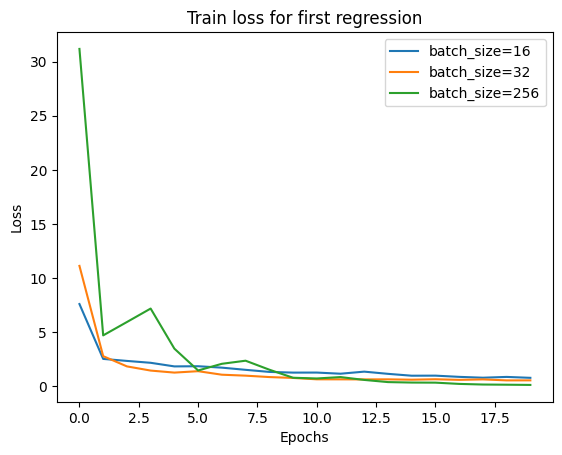

In [ ]:
test_batch_norm(X1, y1, 'first regression')

Для первой регресии худший результат достигается при batch_size=256. Ошибка на тестовом множестве значительно хуже и модель сходится дольше. Результаты на batch_size=16 и batch_size=32 оказались примерно одинаковыми.

100%|██████████| 20/20 [00:03<00:00,  5.58it/s]


Test error for batch size=16: 0.8192951083183289


100%|██████████| 20/20 [00:02<00:00,  9.48it/s]


Test error for batch size=32: 1.099712610244751


100%|██████████| 20/20 [00:00<00:00, 25.35it/s]


Test error for batch size=256: 11.514204025268555


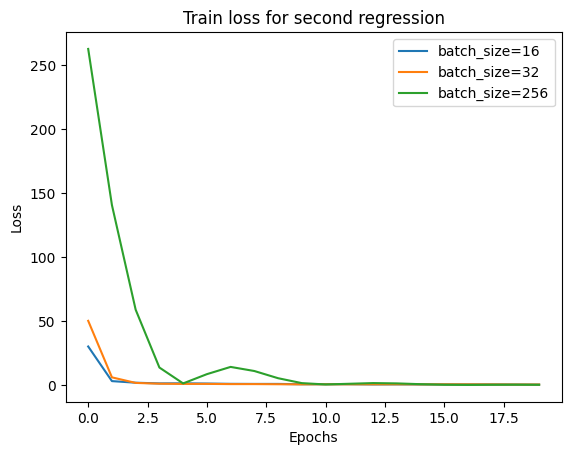

In [ ]:
test_batch_norm(X2, y2, 'second regression')

Здесь также хуже всего себя показал batch_size=256. Лучшим оказался batch_size=16 выдав наименьшую тестовую ошибку.

100%|██████████| 20/20 [00:02<00:00,  7.59it/s]


Test error for batch size=16: 0.5574043393135071


100%|██████████| 20/20 [00:01<00:00, 12.87it/s]


Test error for batch size=32: 0.5043778419494629


100%|██████████| 20/20 [00:00<00:00, 45.72it/s]


Test error for batch size=256: 0.39877647161483765


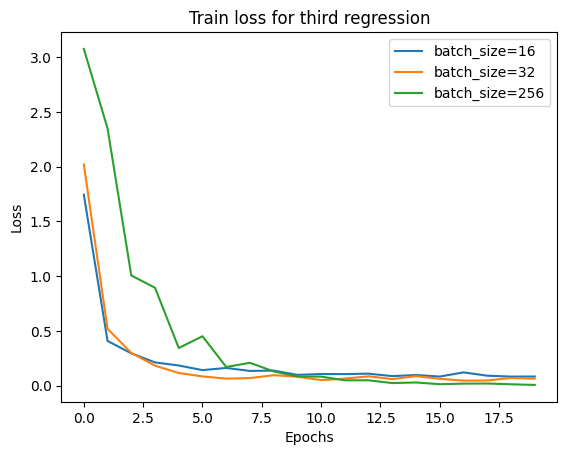

In [ ]:
test_batch_norm(X3, y3, 'third regression')

Здесь batch_size=32 немного обогнал batch_size=16 и по сходимости и по тестовой ошибке.

Однако в среднем лучшим оказывается batch_size=16.

In [ ]:
best_batch_size = 16

### Часть 2. Тестирование дропаута и батчнорма.

In [ ]:
def comparing_batch_norm_dropout(X, y, title):
    models = [(RegressionModel(), 'base model'),
              (RegressionModel(use_batch_norm=True), 'model with batch norm'),
              (RegressionModel(use_dropout=True,), 'model with dropout'),
              (RegressionModel(use_batch_norm= True, use_dropout=True),
                'model with batch norm and dropout')
              ]
    for model, name in models:
        train_total_loss, test_error = run(X, y, model, best_batch_size)
        print(f'Test error for {name}: {test_error}')
        plt.plot(train_total_loss, label=name)

    plt.title(f'Train loss for {title}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

100%|██████████| 20/20 [00:02<00:00,  7.32it/s]


Test error for base model: 2.839712619781494


100%|██████████| 20/20 [00:04<00:00,  4.63it/s]


Test error for model with batch norm: 2.955002784729004


100%|██████████| 20/20 [00:02<00:00,  8.62it/s]


Test error for model with dropout: 2.138702869415283


100%|██████████| 20/20 [00:02<00:00,  6.67it/s]


Test error for model with batch norm and dropout: 2.63893985748291


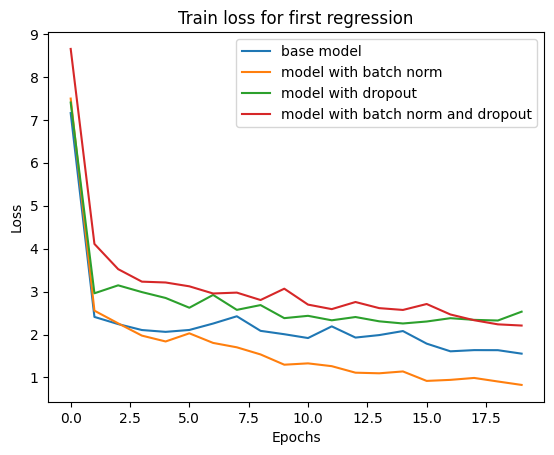

In [ ]:
comparing_batch_norm_dropout(X1, y1, 'first regression')

100%|██████████| 20/20 [00:02<00:00,  9.44it/s]


Test error for base model: 0.5049858689308167


100%|██████████| 20/20 [00:02<00:00,  6.82it/s]


Test error for model with batch norm: 1.1740516424179077


100%|██████████| 20/20 [00:03<00:00,  6.15it/s]


Test error for model with dropout: 0.36869141459465027


100%|██████████| 20/20 [00:02<00:00,  6.84it/s]


Test error for model with batch norm and dropout: 1.245714783668518


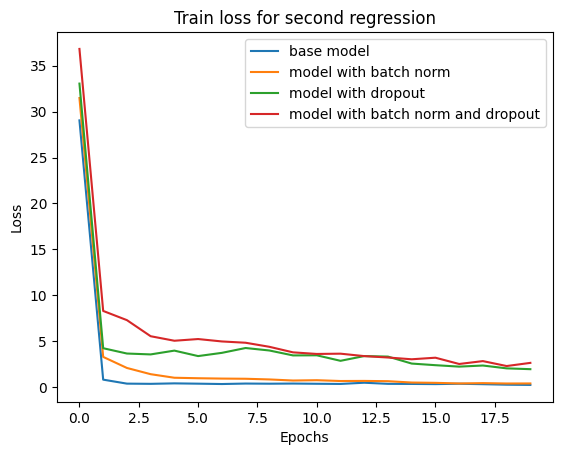

In [ ]:
comparing_batch_norm_dropout(X2, y2, 'second regression')

100%|██████████| 20/20 [00:02<00:00,  7.84it/s]


Test error for base model: 0.5844538807868958


100%|██████████| 20/20 [00:02<00:00,  7.33it/s]


Test error for model with batch norm: 0.546967089176178


100%|██████████| 20/20 [00:02<00:00,  8.38it/s]


Test error for model with dropout: 0.4674661457538605


100%|██████████| 20/20 [00:03<00:00,  6.59it/s]


Test error for model with batch norm and dropout: 0.6362335085868835


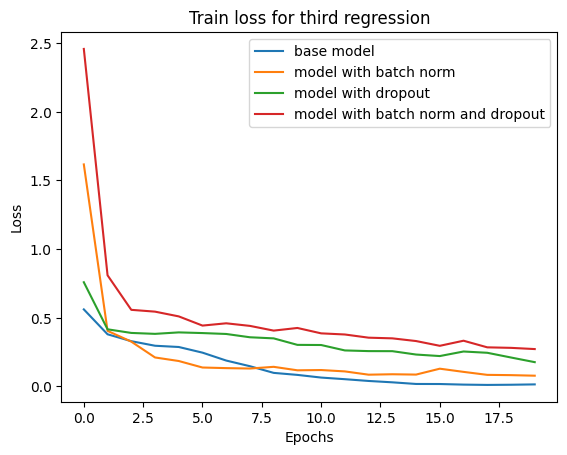

In [ ]:
comparing_batch_norm_dropout(X3, y3, 'third regression')

Использование дропаута на всех регрессиях показало себя лучше всего. Батчева нормализация повысила ошибку на 1 и 2 регрессиях относительно их бейзлайна и слегка понизила её на 3 регресии. Совместное использование батчевой нормализации и дропаута же наоборот на 3 регрессии повысило ошибку и отработало хуже чем батчева нормализация.

Стоит отметить, что в своей реализации я не использовала дропаут на последнем слое сети, так как он делает предсказанные значения менее сатбильными. При его использовании результаты дропаута сильно ухудшаются.

### Вывод

1. Для такого маленького набора данных batch_size=256 оказался слишком большим. На батчах небольшого размера моя модель быстрее сходится и показывает меньшую ошибку. Однако, если бы датасет был большего размера, использование батча большего размера имело бы смысл для улучшения производительности.

2. Батчева нормализация показала невпечатляющие результаты. Скорее всего это связано с тем, что был выбран batch_size=16. Батчева нормализация лучше работает на батчах большего размера, так как на них подсчет среднего и дисперсии становятся более точными.

3. Дропаут хорошо подошел для данной задачи.